In [11]:
# todos

# 1) set seed (pending)
# 2) set save callback
# 3) set history save
# 4) plot loss/accuracy graph
# 5) draw gradcams

In [12]:
#check if gpu is enabled or not

import tensorflow as tf

# Check the available physical devices
physical_devices = tf.config.list_physical_devices()

# Print information about the devices
print("Available devices:")
for device in physical_devices:
    print(device)

# Check if GPU is available and being used
if any("GPU" in device.device_type for device in physical_devices):
    print("\nTensorFlow is using GPU!")
else:
    print("\nTensorFlow is using CPU.")



Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

TensorFlow is using GPU!


## Imports

In [15]:
import json
import os
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import load_model
from enum import Enum
from datetime import datetime
import numpy as np

SystemError: <built-in function isinstance> returned a result with an error set

# Enums and Classes

In [ ]:
# MODEL_ARCHI specifies which model architecture we want to use

# ENVIRONMENT used for differenet level of environment settings
ENVIRONMENT = Enum("ENVIRONMENT" ,["development", "debug" , "release" ,"production"])

In [8]:
!pwd

/home/chestxray/Desktop/X-Ray Imaging/notebooks/cheXNet/ResNet101V2


# configurations

In [9]:
project_path = '/home/chestxray/Desktop/X-Ray Imaging/'
# project_path = '/content/drive/MyDrive/Research/X-Ray Imaging'

seed = 42
environment = ENVIRONMENT.development

NameError: name 'ENVIRONMENT' is not defined

In [7]:
# don't change these lines


model_archi_name = "ResNet101V2"
model_folder_path = os.path.join(os.getcwd(), 'model')
model_save_path = os.path.join(model_folder_path, f'last_epoch_model.keras')

dataset_path = os.path.join(project_path, 'dataset')


## creating directoris if doesn't exist

In [8]:
os.makedirs(model_folder_path, exist_ok=True)

## visualizing class distributions

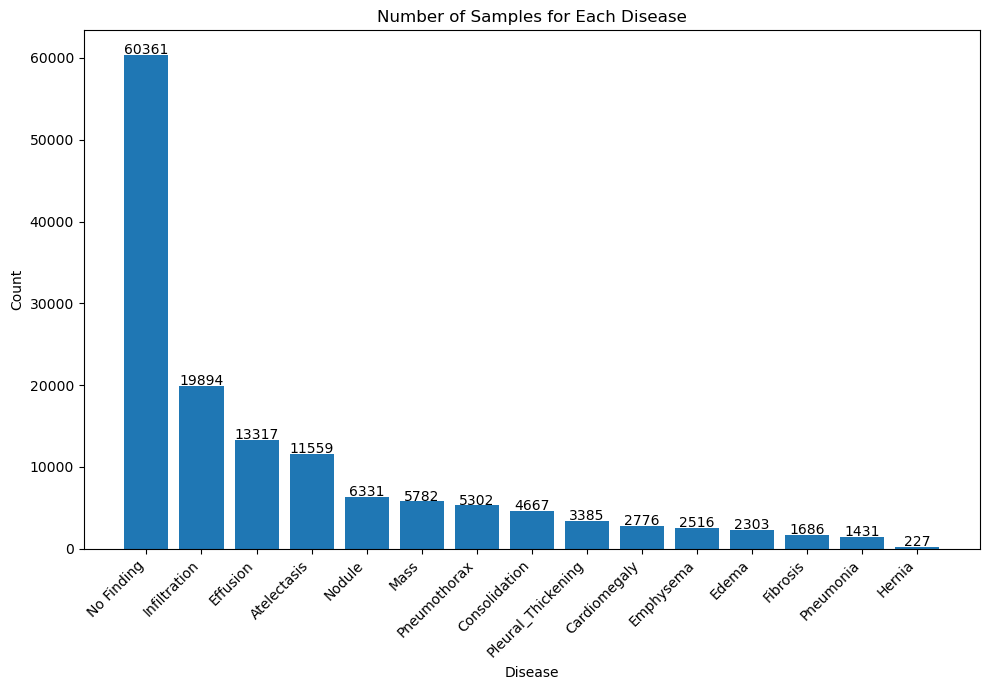

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv(os.path.join(dataset_path, 'data_entry_chest_with_one_hot.csv'))

# Define the disease labels dictionary
# labels_dict = {"Atelectasis": 0, "Cardiomegaly": 1, "Consolidation": 2, "Edema": 3,
#                "Effusion": 4, "Emphysema": 5, "Fibrosis": 6, "Hernia": 7,
#                "Infiltration": 8, "Mass": 9, "No Finding": 10, "Nodule": 11,
#                "Pleural_Thickening": 12, "Pneumonia": 13, "Pneumothorax": 14}

# load the disease labels dictionary stored in json file
with open(os.path.join(dataset_path,'labels' , 'label_to_index.json'), 'r') as f:
    labels_dict = json.load(f)

# Create a dictionary to store the counts for each disease
disease_counts = {label: 0 for label in labels_dict.keys()}

# Count the occurrences of each disease using the One-Hot Encoded Labels column
for index, row in data.iterrows():
    one_hot_labels = eval(row['One-Hot Encoded Labels'])  # Convert string to list
    for disease, idx in labels_dict.items():
        disease_counts[disease] += one_hot_labels[idx]

# Sort disease counts in descending order for plotting
sorted_disease_counts = dict(sorted(disease_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the data
plt.figure(figsize=(10, 7))
plt.bar(sorted_disease_counts.keys(), sorted_disease_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Number of Samples for Each Disease')

# Display counts on top of the bars
for i, (disease, count) in enumerate(sorted_disease_counts.items()):
    plt.text(i, count + 100, str(count), ha='center')

plt.tight_layout()
plt.show()


# Loading Arrays

In [10]:
# Define the paths where your arrays are saved

#Training array path
# # image_array_path1 = '/content/drive/MyDrive/X-Ray Imaging/dataset/images/train/image_array_train.npy'
# image_array_train_path = os.path.join(dataset_path, 'images', 'train', 'image_array_train.npy')
# # label_array_path1 = '/content/drive/MyDrive/X-Ray Imaging/dataset/labels/train/label_array_train.npy'
# label_array_train_path = os.path.join(dataset_path, 'labels', 'train', 'label_array_train.npy')

image_array_train_balanced_path = os.path.join(dataset_path, 'images', 'train', 'image_array_train_balanced.npy')
label_array_train_balanced_path = os.path.join(dataset_path, 'labels', 'train', 'label_array_train_balanced.npy')



#Validation array path
# image_array_path2 = '/content/drive/MyDrive/X-Ray Imaging/dataset/images/val/image_array_val.npy'
image_array_val_path = os.path.join(dataset_path, 'images', 'val', 'image_array_val.npy')
# label_array_path2 = '/content/drive/MyDrive/X-Ray Imaging/dataset/labels/val/label_array_val.npy'
label_array_val_path = os.path.join(dataset_path, 'labels', 'val', 'label_array_val.npy')

In [11]:
import numpy as np

#Loading train data
image_array_train = np.load(image_array_train_balanced_path, mmap_mode='r')
label_array_train = np.load(label_array_train_balanced_path, mmap_mode='r')

#Loading val data
image_array_val = np.load(image_array_val_path, mmap_mode='r')
label_array_val = np.load(label_array_val_path, mmap_mode='r')

In [12]:
# print shapes with message
print("image_array_train shape:", image_array_train.shape)
print("label_array_train shape:", label_array_train.shape)

print("image_array_val shape:", image_array_val.shape)
print("label_array_val shape:", label_array_val.shape)


image_array_train shape: (61034, 224, 224, 3)
label_array_train shape: (61034, 14)
image_array_val shape: (16007, 224, 224, 3)
label_array_val shape: (16007, 14)


# undersampling (one time only)

In [13]:
# # Step 1: Identify "No Finding" samples (all labels are 0s)
# no_finding_indices = np.where(label_array_train.sum(axis=1) == 0)[0]
# diseased_indices = np.where(label_array_train.sum(axis=1) > 0)[0]

# # Step 2: Decide how many healthy samples to keep (e.g., same as diseased count)
# num_diseased = len(diseased_indices)
# undersample_count = num_diseased  # or use a ratio like int(num_diseased * 0.5)


In [14]:
# print(f"num_diseased : {num_diseased}")
# print(f"undersample_count : {undersample_count}")

num_diseased : 30517
undersample_count : 30517


In [15]:
# len(no_finding_indices) + len(diseased_indices)

70517

In [16]:
# # Step 3: Randomly select a subset of healthy samples
# np.random.seed(42)
# undersampled_no_finding_indices = np.random.choice(no_finding_indices, size=undersample_count, replace=False)

# # Step 4: Combine indices
# final_indices = np.concatenate([diseased_indices, undersampled_no_finding_indices])
# np.random.shuffle(final_indices)

In [17]:
# # Step 5: Subset the arrays
# image_array_train_balanced = image_array_train[final_indices]
# label_array_train_balanced = label_array_train[final_indices]

In [18]:
# image_array_train_balanced.shape

(61034, 224, 224, 3)

In [21]:
# image_array_train_balanced_path = os.path.join(dataset_path, 'images', 'train', 'image_array_train_balanced.npy')
# label_array_train_balanced_path = os.path.join(dataset_path, 'labels', 'train', 'label_array_train_balanced.npy')

# np.save(image_array_train_balanced_path, image_array_train_balanced)
# np.save(label_array_train_balanced_path, label_array_train_balanced)

# Processing Image

In [ ]:
# import numpy as np

# # Paths for saving the processed arrays
# processed_image_array_train_path = os.path.join(dataset_path, 'images', 'train', 'processed_densenet_image_array_train.npy')
# processed_image_array_val_path = os.path.join(dataset_path, 'images', 'val', 'processed_densenet_image_array_val.npy')


# # Process the image arrays
# image_array_train_processed = tf.keras.applications.densenet.preprocess_input(image_array_train)
# image_array_val_processed = tf.keras.applications.densenet.preprocess_input(image_array_val)

# # Save the processed arrays
# np.save(processed_image_array_train_path, image_array_train_processed)
# np.save(processed_image_array_val_path, image_array_val_processed)

# # Verify and print the saved shapes
# print("Processed image_array_train shape:", image_array_train_processed.shape)
# print("Processed image_array_val shape:", image_array_val_processed.shape)
# print(f"Processed training images saved to {processed_image_array_train_path}")
# print(f"Processed validation images saved to {processed_image_array_val_path}")


# Calculating Class Weights

In [13]:
import numpy as np

# Weight calculation
total_samples = label_array_train.shape[0]
positive_counts = np.sum(label_array_train, axis=0)
negative_counts = total_samples - positive_counts
positive_weights = np.where(positive_counts == 0, 0, total_samples / (2 * positive_counts))
negative_weights = np.where(negative_counts == 0, 0, total_samples / (2 * negative_counts))

# Normalize positive weights
max_positive_weight = 10.0  # Cap positive weights
positive_weights = np.minimum(positive_weights, max_positive_weight)
positive_weights_dict = {c: float(positive_weights[c]) for c in range(14)}
negative_weights_dict = {c: float(negative_weights[c]) for c in range(14)}

print("Normalized Positive Weights:", positive_weights_dict)
print("Negative Weights:", negative_weights_dict)

Normalized Positive Weights: {0: 4.335416962636738, 1: 10.0, 2: 10.0, 3: 10.0, 4: 4.135655237837105, 5: 10.0, 6: 10.0, 7: 10.0, 8: 2.5032400951521616, 9: 9.381186596987396, 10: 7.9121078558465125, 11: 10.0, 12: 10.0, 13: 10.0}
Negative Weights: {0: 0.5651819612927123, 1: 0.5117811802981771, 2: 0.518441126004451, 3: 0.5096529610207422, 4: 0.5687633957692666, 5: 0.5098999147855436, 6: 0.5087862620873624, 7: 0.5010590263525162, 8: 0.6247978215916303, 9: 0.5281493916685416, 10: 0.533728597163195, 11: 0.5152026741849982, 12: 0.5061030216590932, 13: 0.5180187061839046}


In [14]:
print(f"positive counts : {positive_counts}")
print(f"negative counts : {negative_counts}")

positive counts : [ 7039  1405  2171  1156  7379  1185  1054   129 12191  3253  3857  1801
   736  2123]
negative counts : [53995 59629 58863 59878 53655 59849 59980 60905 48843 57781 57177 59233
 60298 58911]


# Creating data generator

In [15]:
#code that correctly works with shuffle

import numpy as np
from tensorflow.keras.utils import Sequence
import cv2

class MemMappedDataGenerator(Sequence):
    def __init__(self, image_array, label_array, batch_size, train=True, seed=None):
        super().__init__()

        self.image_array = image_array
        self.label_array = label_array
        self.batch_size = batch_size
        self.train = train
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Random generator for reproducibility
        self.indices = np.arange(self.image_array.shape[0])

        # if train:
        #     self.augment = tf.keras.Sequential([
        #         tf.keras.layers.Rescaling(1./255),
        #         tf.keras.layers.RandomFlip("horizontal"),
        #         tf.keras.layers.RandomRotation(0.05),
        #         tf.keras.layers.RandomZoom(0.1),
        #         tf.keras.layers.RandomContrast(0.1)
        #     ])
        # else:
        #     self.augment = tf.keras.Sequential([
        #         tf.keras.layers.Rescaling(1./255)
        #     ])

    def __len__(self):
        return int(np.ceil(len(self.image_array) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # batch_x = [self.image_array[i] for i in batch_indices]
        batch_x = np.stack(self.image_array[batch_indices]) # slightly faster than above
        batch_y = [self.label_array[i] for i in batch_indices]

        if self.train:
            batch_x = self.augmentor(batch_x)
        else:
            batch_x = batch_x / 255.0
    
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.train:
            self.rng.shuffle(self.indices)  # Shuffle using the random generator

    def augmentor(self, images):
        'Apply OpenCV-based data augmentation per image'
        augmented_images = []
    
        for img in images:
            # Random horizontal flip
            if self.rng.random() < 0.5:
                img = cv2.flip(img, 1)
    
            # Random rotation
            if self.rng.random() < 0.5:
                angle = self.rng.uniform(-10, 10)
                h, w = img.shape[:2]
                M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
                img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)
    
            # Random brightness
            if self.rng.random() < 0.5:
                factor = self.rng.uniform(0.9, 1.1)
                img = np.clip(img * factor, 0, 255).astype(np.uint8)
    
            # Random zoom (crop and resize back)
            if self.rng.random() < 0.5:
                zoom_factor = self.rng.uniform(0.9, 1.0)
                h, w = img.shape[:2]
                ch = int(h * zoom_factor)
                cw = int(w * zoom_factor)
                top = self.rng.integers(0, h - ch + 1)
                left = self.rng.integers(0, w - cw + 1)
                img = img[top:top+ch, left:left+cw]
                img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
    
            augmented_images.append(img)
    
        return np.array(augmented_images) / 255.0
    
    
# Create generators using the memory-mapped arrays
train_gen = MemMappedDataGenerator(image_array_train, label_array_train, batch_size=32, train=True, seed=seed)
val_gen = MemMappedDataGenerator(image_array_val, label_array_val, batch_size=16, train=False)

In [16]:
# def augmentor(self, images):
#     	'Apply data augmentation'
#     	sometimes = lambda aug: iaa.Sometimes(0.5, aug)
#     	seq = iaa.Sequential(
# 				[
# 						# apply the following augmenters to most images
# 						sometimes(iaa.Affine(
# 								scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
# 								# scale images to 80-120% of their size, individually per axis
# 								translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
# 								# translate by -20 to +20 percent (per axis)
# 								rotate=(-10, 10),  # rotate by -45 to +45 degrees
# 								shear=(-5, 5),  # shear by -16 to +16 degrees
# 								order=[0, 1],
# 								# use any of scikit-image's warping modes (see 2nd image from the top for examples)
# 						)),
# 						# execute 0 to 5 of the following (less important) augmenters per image
# 						# don't execute all of them, as that would often be way too strong
# 						iaa.SomeOf((0, 5),
# 						           [iaa.OneOf([
# 								            iaa.GaussianBlur((0, 1.0)),
# 								            # blur images with a sigma between 0 and 3.0
# 								            iaa.AverageBlur(k=(3, 5)),
# 								            # blur image using local means with kernel sizes between 2 and 7
# 								            iaa.MedianBlur(k=(3, 5)),
# 								            # blur image using local medians with kernel sizes between 2 and 7
# 						            ]),
# 						            iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)),
# 						            # sharpen images
# 						            iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
# 						            # emboss images
# 						            iaa.AdditiveGaussianNoise(loc=0,
# 						                                      scale=(0.0, 0.01 * 255),
# 						                                      per_channel=0.5),
# 						            # add gaussian noise to images
# 						            iaa.Invert(0.01, per_channel=True),
# 						            # invert color channels
# 						            iaa.Add((-2, 2), per_channel=0.5),
# 						            # change brightness of images (by -10 to 10 of original value)
# 						            iaa.AddToHueAndSaturation((-1, 1)),
# 						            # change hue and saturation
# 						            # either change the brightness of the whole image (sometimes
# 						            # per channel) or change the brightness of subareas
# 						            iaa.OneOf([
# 								            iaa.Multiply((0.9, 1.1), per_channel=0.5),
# 								            iaa.FrequencyNoiseAlpha(
# 										            exponent=(-1, 0),
# 										            first=iaa.Multiply((0.9, 1.1),
# 										                               per_channel=True),
# 										            second=iaa.ContrastNormalization(
# 												            (0.9, 1.1))
# 								            )
# 						            ]),
# 						            sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5),
# 						                                                sigma=0.25)),
# 						            # move pixels locally around (with random strengths)
# 						            sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
# 						            # sometimes move parts of the image around
# 						            sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
# 						            ],
# 						           random_order=True
# 						           )
# 				],
# 				random_order=True
# 		)
#     	return seq.augment_images(images)


In [17]:
image = train_gen.__getitem__(1)[0]


print(f"image.shape : {image.shape}")
print(f"min : {np.min(image)} max : {np.max(image)}")

image.shape : (32, 224, 224, 3)
min : 0.0 max : 1.0


# Model

In [18]:
# settings seeds
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [19]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D

In [24]:

isLoaded = False

try:
    model = load_model(model_save_path)
    print("Loaded existing model.")
    isLoaded = True
except:
    print("No existing model found. Continuing with model creation.")

    base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Add custom layers for multi-label classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(14)(x)  # 14 classes for multi-label classification
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

No existing model found. Continuing with model creation.


In [25]:
# import tensorflow.keras.backend as K
# import tensorflow as tf

# @tf.keras.utils.register_keras_serializable()
# def loss_fn(y_true, y_pred):
#     epsilon = K.epsilon()  # A small constant to avoid log(0)
    
#     # # Use simple binary cross entropy for validation (when training is False)
#     # if not training:
#     #     print("not trianing")
#     #     return tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
#     # Otherwise, use weighted loss for training
#     loss = 0
#     for c in range(y_true.shape[1]):  # Loop over all 14 or 15 classes
#         y_pred_c = K.clip(y_pred[:, c], epsilon, 1 - epsilon)  # Clip predictions to avoid 0 or 1
#         loss -= (
#             positive_weights[c] * y_true[:, c] * K.log(y_pred_c) + 
#             negative_weights[c] * (1 - y_true[:, c]) * K.log(1 - y_pred_c)
#         )
#     return K.mean(loss)  # Return the mean loss across the batch


In [26]:
import tensorflow as tf
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
def weighted_bce_with_logits_loss(y_true, y_pred):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Define weights as tensors (use your calculated weights)
    positive_weights = tf.constant(
        list(positive_weights_dict.values()), dtype=tf.float32
    )  # Shape: [14]
    negative_weights = tf.constant(
        list(negative_weights_dict.values()), dtype=tf.float32
    )  # Shape: [14]
    
    # Compute BCE with logits (vectorized over all classes)
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)  # Shape: [batch_size, 14]
    
    # Apply weights: positive weight for positive samples, negative weight for negative samples
    weights = positive_weights * y_true + negative_weights * (1 - y_true)  # Shape: [batch_size, 14]
    weighted_bce = bce * weights
    
    # Mean loss across batch and classes
    return tf.reduce_mean(weighted_bce)

In [27]:
# from tensorflow.keras.initializers import GlorotUniform

# # Get the final layer
# final_layer = model.layers[-1]
# # Create a new Dense layer with the same configuration but new weights
# new_layer = Dense(
#     units=final_layer.units,
#     kernel_initializer=GlorotUniform(),
#     bias_initializer='zeros'
# )
# # Replace the final layer
# model.pop()  # Remove the old final layer
# model.add(new_layer)  # Add the new layer
# print("Reinitialized final layer.")

In [28]:
# Compile the model
# optimizer=Adam(learning_rate=1e-3, 	                 
#                      beta_1=0.9,
# 	                 beta_2=0.999,
# 	                 epsilon=1e-08,
# 	                 weight_decay=1e-4,
# 	                 amsgrad=False)

optimizer=Adam(learning_rate=0.005)


auc = tf.keras.metrics.AUC(multi_label=True, num_labels=14, name='AUC')

model.compile(optimizer=optimizer, loss=weighted_bce_with_logits_loss , metrics=['accuracy', auc])

# Model summary
# model.summary()

if isLoaded:
    print("Loaded existing model.")
else:
    print("No existing model found. Created new model.")

No existing model found. Created new model.


In [29]:
# # Model Checkpoint to save the best model
# model_checkpoint = ModelCheckpoint(
#     model_save_path,
#     save_best_only=True,
#     monitor='val_loss',
#     mode='min',
#     verbose=1
# )

In [30]:
import os
import json
from tensorflow.keras.callbacks import Callback

class SaveBestAndAllModelsCallback(Callback):
    def __init__(self, save_dir, monitor='val_loss', mode='min'):
        """
        :param save_dir: Directory where models and history will be saved
        :param monitor: Metric to monitor (default: 'val_loss')
        :param mode: Mode for comparison ('min' or 'max' depending on the metric)
        """
        super(SaveBestAndAllModelsCallback, self).__init__()
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.monitor = monitor
        self.mode = mode
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.best_epoch = None

        # Initialize lists to store history of models and metrics
        self.all_models_history = []
        self.best_models_history = []


        # Load previous histories if they exist
        self.load_existing_histories()
        # Automatically load the best epoch if it exists
        self.load_best_epoch_from_history()

        self.start_epoch = len(self.all_models_history)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Save the model for the current epoch (this will overwrite the previous epoch model)
        all_model_path = model_save_path
        self.model.save(all_model_path)
        print(f"Model saved for epoch {epoch+1}: {all_model_path}")

        # Store training history for all models
        self.all_models_history.append({
            'epoch': self.start_epoch + epoch + 1,
            'train_loss': logs.get('loss'),
            'val_loss': logs.get('val_loss'),
            'train_accuracy': logs.get('accuracy'),
            'val_accuracy': logs.get('val_accuracy'),
            'AUC': logs.get('AUC')
        })

        # Check if the current epoch gives the best result for the monitored metric
        current_value = logs.get(self.monitor)
        if current_value is not None:
            is_improvement = (current_value < self.best_value) if self.mode == 'min' else (current_value > self.best_value)
            if is_improvement:
                self.best_value = current_value
                self.best_epoch = epoch + 1

                # Save the best model (this will overwrite the previous best model)
                best_model_path = os.path.join(self.save_dir, "best_model.keras")
                self.model.save(best_model_path)
                print(f"Best model updated at epoch {self.best_epoch}: {best_model_path}")

                # Store the training history for the best model
                self.best_models_history.append({
                    'epoch': epoch + 1,
                    'train_loss': logs.get('loss'),
                    'val_loss': logs.get('val_loss'),
                    'train_accuracy': logs.get('accuracy'),
                    'val_accuracy': logs.get('val_accuracy'),
                    'AUC': logs.get('AUC')
                })

        # Save the training history for all models to a JSON file
        all_models_history_path = os.path.join(self.save_dir, "all_models_history.json")
        with open(all_models_history_path, "w") as f:
            json.dump(self.all_models_history, f, indent=4)

        # Save the training history for the best model to a JSON file
        best_models_history_path = os.path.join(self.save_dir, "best_models_history.json")
        if self.best_epoch == epoch + 1:
            with open(best_models_history_path, "w") as f:
                json.dump(self.best_models_history, f, indent=4)

    def load_existing_histories(self):
        """
        Loads existing histories from JSON files if they exist.
        """
        all_models_history_path = os.path.join(self.save_dir, "all_models_history.json")
        best_models_history_path = os.path.join(self.save_dir, "best_models_history.json")

        if os.path.exists(all_models_history_path):
            with open(all_models_history_path, "r") as f:
                self.all_models_history = json.load(f)
                print(f"Loaded existing all models history with {len(self.all_models_history)} entries.")

        if os.path.exists(best_models_history_path):
            with open(best_models_history_path, "r") as f:
                self.best_models_history = json.load(f)
                print(f"Loaded existing best models history with {len(self.best_models_history)} entries.")

    def load_best_epoch_from_history(self):
        """
        Automatically loads the best epoch number from the saved history file, if it exists.
        """
        best_models_history_path = os.path.join(self.save_dir, "best_models_history.json")
        if os.path.exists(best_models_history_path):
            with open(best_models_history_path, 'r') as f:
                best_models_history = json.load(f)
                if best_models_history:
                    self.best_epoch = best_models_history[-1]['epoch']  # Get the best epoch from the last entry
                    print(f"Loaded best epoch from history: Epoch {self.best_epoch}")
                else:
                    print("No best epoch found in history, starting fresh.")
        else:
            print("No history found, starting fresh.")

    def get_best_epoch(self):
        """
        Function to retrieve the best epoch number (based on the saved history)
        """
        return self.best_epoch

# Example usage:
# Callback instance (best_epoch is automatically loaded at the start of training)
save_best_and_all_models = SaveBestAndAllModelsCallback(save_dir=model_folder_path, monitor='val_loss', mode='min')


No history found, starting fresh.


In [31]:
# prompt: load last all_saved model epoch number from "all_models_history.json")

def load_last_saved_epoch(model_folder_path):
  """Loads the last saved epoch number from the 'all_models_history.json' file."""
  all_models_history_path = os.path.join(model_folder_path, "all_models_history.json")
  if os.path.exists(all_models_history_path):
    with open(all_models_history_path, 'r') as f:
      all_models_history = json.load(f)
      if all_models_history:
        last_saved_epoch = all_models_history[-1]['epoch']
        return last_saved_epoch
      else:
        print("No epochs found in all_models_history.json")
        return 0
  else:
    print("all_models_history.json not found.")
    return 0


last_saved_epoch = load_last_saved_epoch(model_folder_path)
if last_saved_epoch:
  print(f"Last saved epoch: {last_saved_epoch}")
else:
  print(f"No last saved epoch found. Starting with epoch {last_saved_epoch}")

all_models_history.json not found.
No last saved epoch found. Starting with epoch 0


In [32]:
# # Define the learning rate schedule function
# def get_learning_rate_scheduler(start_epoch):
#   def lr_schedule(epoch):
#       absolute_epoch = start_epoch + epoch
#       if absolute_epoch < 60:
#           return 0.0005
#       elif 60 <= absolute_epoch < 80:
#           return 0.00005
#       elif 80 <= absolute_epoch < 90:
#           return 0.00003
#       else:
#           return 0.00001

#   return LearningRateScheduler(lr_schedule, verbose=1)

# lr_scheduler = get_learning_rate_scheduler(last_saved_epoch)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

lr_plateau_callback = ReduceLROnPlateau(monitor='val_loss',
	                                            patience=5,
	                                            verbose=1,
	                                            factor=0.5,
	                                            min_lr=0.00000001)

early_stop = EarlyStopping(monitor="val_loss",
	                           mode="min",
	                           patience=12)

In [34]:
import tensorflow as tf
import numpy as np

class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, max_lr=1e-2, min_lr=1e-5, cycle_length=10, cycle_mult=1):
        super().__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.cycle_length = cycle_length
        self.cycle_mult = cycle_mult
        self.current_cycle_length = cycle_length
        self.current_epoch = 0
        self.history = {}

    def cosine_annealing(self, epoch):
        cycle_progress = (epoch % self.current_cycle_length) / self.current_cycle_length
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(np.pi * cycle_progress))
        return lr

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch
        lr = self.cosine_annealing(epoch)
        # Update learning rate safely
        if hasattr(self.model.optimizer, 'learning_rate'):
            try:
                # Attempt to assign directly
                self.model.optimizer.learning_rate.assign(lr)
            except AttributeError:
                # Fallback: Set learning_rate as a new tensor
                self.model.optimizer.learning_rate = lr
        print(f"Epoch {epoch}: Setting learning rate to {lr:.6f}")
        if (epoch + 1) % self.current_cycle_length == 0:
            self.current_cycle_length = int(self.current_cycle_length * self.cycle_mult)
            print(f"Restarting cycle with length {self.current_cycle_length} epochs")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history.setdefault('lr', []).append(float(self.model.optimizer.learning_rate))
        
cosine_scheduler = CosineAnnealingScheduler(max_lr=1e-1, min_lr=1e-5, cycle_length=10, cycle_mult=1)

In [35]:
from tensorflow.keras.callbacks import TensorBoard

# Set up the log directory for TensorBoard
log_dir = os.path.join(model_folder_path, "tensorboard_logs",f"{model_archi_name}-{last_saved_epoch}" ) # model_name-start_epoch
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## training

In [36]:
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt

# Train the model using the dataset
# history = model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[model_checkpoint, lr_scheduler])
# history = model.fit(train_gen, epochs=100,  callbacks=[model_checkpoint, lr_scheduler])
# history = model.fit(train_gen, epochs=100-last_saved_epoch, validation_data=val_gen, callbacks=[save_best_and_all_models, lr_scheduler, tensorboard_callback])

history = model.fit(train_gen, epochs=25-last_saved_epoch, validation_data=val_gen, callbacks=[save_best_and_all_models, lr_plateau_callback, early_stop, tensorboard_callback ])
# history = model.fit(train_gen, epochs=35-last_saved_epoch, validation_data=val_gen, callbacks=[save_best_and_all_models, cosine_scheduler , early_stop, tensorboard_callback ])

Epoch 1/25


2025-05-18 20:30:50.388627: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1908/1908 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - AUC: 0.5828 - accuracy: 0.1628 - loss: 0.5114

KeyboardInterrupt: 

## Plotting last saved model

In [ ]:
 # prompt: plot loss and accuracy graph of all_models_history.json

import json
import matplotlib.pyplot as plt

# Load the training history from the JSON file
with open(f'{model_folder_path}/all_models_history.json', 'r') as f:
    history = json.load(f)

# Extract loss and accuracy values
train_loss = [entry['train_loss'] for entry in history]
val_loss = [entry['val_loss'] for entry in history]
train_accuracy = [entry['train_accuracy'] for entry in history]
val_accuracy = [entry['val_accuracy'] for entry in history]
epochs = [entry['epoch'] for entry in history]


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Plotting best saved model

In [ ]:
# prompt: similary plot best_saved model accraucy and loss by loading from json file

# Load the training history from the JSON file
with open(f'{model_folder_path}/best_models_history.json', 'r') as f:
    best_history = json.load(f)

# Extract loss and accuracy values
best_train_loss = [entry['train_loss'] for entry in best_history]
best_val_loss = [entry['val_loss'] for entry in best_history]
best_train_accuracy = [entry['train_accuracy'] for entry in best_history]
best_val_accuracy = [entry['val_accuracy'] for entry in best_history]
best_epochs = [entry['epoch'] for entry in best_history]


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_epochs, best_train_loss, label='Train Loss')
plt.plot(best_epochs, best_val_loss, label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(best_epochs, best_train_accuracy, label='Train Accuracy')
plt.plot(best_epochs, best_val_accuracy, label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### model predictions

In [ ]:
## loads best saved model
model = load_model(model_save_path)

In [ ]:
# prompt: get y_pred using val_gen

y_pred = model.predict(val_gen)

In [ ]:
y_true = label_array_val

In [ ]:
# from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, accuracy_score
# import numpy as np
# import pandas as pd

# # Assuming y_true contains the one-hot encoded true labels (shape: [n_samples, n_classes])
# # and y_pred contains the sigmoid outputs (shape: [n_samples, n_classes])

# # Threshold the sigmoid outputs to obtain binary predictions
# y_pred_binary = (y_pred >= 0.5).astype(int)
# # y_pred_binary= (y_pred >= optimal_thresholds).astype(int)

# # # Define the label mapping
# # label_mapping = {
# #     0: "Atelectasis",
# #     1: "Cardiomegaly",
# #     2: "Consolidation",
# #     3: "Edema",
# #     4: "Effusion",
# #     5: "Emphysema",
# #     6: "Fibrosis",
# #     7: "Hernia",
# #     8: "Infiltration",
# #     9: "Mass",
# #     10: "No Finding",  # This will be ignored in the final report
# #     11: "Nodule",
# #     12: "Pleural_Thickening",
# #     13: "Pneumonia",
# #     14: "Pneumothorax"
# # }

# # loads label mapping stored in json file
# with open(os.path.join(dataset_path,'labels' , 'index_to_label.json'), 'r') as f:
#     label_mapping = json.load(f)

# label_mapping = {int(k): v for k, v in label_mapping.items()}

# # Overall Accuracy (average accuracy per sample)
# sample_accuracy = round(accuracy_score(y_true, y_pred_binary, normalize=True) * 100, 3)

# # AUC per class (one-vs-rest for each class)
# auc_scores = roc_auc_score(y_true, y_pred, average=None)

# # Initialize lists to store per-class metrics
# accuracies = []
# recalls = []
# tnrs = []
# fprs = []
# fnrs = []

# # Calculate per-class metrics
# for i in range(y_true.shape[1]):
#     # Skip "No Finding" class (index 10)
#     if i == 10:
#         continue

#     # True Positives, False Positives, True Negatives, False Negatives
#     tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_binary[:, i]).ravel()

#     # Accuracy for the current class
#     accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 3)
#     accuracies.append(accuracy)

#     # Recall (Sensitivity/TPR) for the current class
#     recall = round(tp / (tp + fn) * 100, 3) if (tp + fn) != 0 else 0.0
#     recalls.append(recall)

#     # True Negative Rate (TNR) or Specificity
#     tnr = round(tn / (tn + fp) *100, 3) if (tn + fp) != 0 else 0.0
#     tnrs.append(tnr)

#     # False Positive Rate (FPR)
#     fpr = round(fp / (fp + tn) * 100, 3) if (fp + tn) != 0 else 0.0
#     fprs.append(fpr)

#     # False Negative Rate (FNR)
#     fnr = round(fn / (fn + tp) * 100, 3) if (fn + tp) != 0 else 0.0
#     fnrs.append(fnr)

# # Exclude AUC for "No Finding" and get disease names for classes other than "No Finding"
# auc_scores_filtered = [round(auc_scores[i]* 100, 3) for i in range(y_true.shape[1]) if i != 10]
# classes_filtered = [label_mapping[i] for i in range(y_true.shape[1]) if i != 10]

# # Combine all metrics into a DataFrame for easier display
# report_df = pd.DataFrame({
#     'Class': classes_filtered,
#     'Accuracy': accuracies,
#     'AUC': auc_scores_filtered,
#     'Recall': recalls,
#     'TNR': tnrs,
#     'FPR': fprs,
#     'FNR': fnrs
# })

# # Calculate averages for each metric
# average_metrics = {
#     'Class': 'Average',
#     'Accuracy': round(np.mean(accuracies), 3),
#     'AUC': round(np.mean(auc_scores_filtered), 3),
#     'Recall': round(np.mean(recalls), 3),
#     'TNR': round(np.mean(tnrs), 3),
#     'FPR': round(np.mean(fprs), 3),
#     'FNR': round(np.mean(fnrs), 3)
# }

# # Append the average row to the DataFrame
# report_df = pd.concat([report_df, pd.DataFrame([average_metrics])], ignore_index=True)

# print("Sample-wise Accuracy:", sample_accuracy)
# print(report_df)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import os
import json

# Assuming y_true contains the one-hot encoded true labels (shape: [n_samples, n_classes])
# and y_pred contains the sigmoid outputs (shape: [n_samples, n_classes])

# Load label mapping stored in JSON file
with open(os.path.join(dataset_path, 'labels', 'index_to_label.json'), 'r') as f:
    label_mapping = json.load(f)
label_mapping = {int(k): v for k, v in label_mapping.items()}

# Initialize variables
optimal_thresholds = []
auc_scores = roc_auc_score(y_true, y_pred, average=None)

# Find optimal thresholds for each class
for i in range(y_true.shape[1]):
    # if i == 10:  # Skip "No Finding" class (index 10)
    #     optimal_thresholds.append(0.5)  # Default threshold
    #     continue

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])

    # Compute Youden's Index
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_thresholds.append(thresholds[optimal_idx])

# Convert predictions to binary using optimal thresholds
y_pred_binary = np.zeros_like(y_pred)
for i in range(y_pred.shape[1]):
    y_pred_binary[:, i] = (y_pred[:, i] >= optimal_thresholds[i]).astype(int)

# Overall Accuracy (average accuracy per sample)
sample_accuracy = round(accuracy_score(y_true, y_pred_binary, normalize=True) * 100, 3)

# Initialize lists to store per-class metrics
accuracies = []
recalls = []
tnrs = []
fprs = []
fnrs = []

# Calculate per-class metrics
for i in range(y_true.shape[1]):

    # True Positives, False Positives, True Negatives, False Negatives
    tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_binary[:, i]).ravel()

    # Accuracy for the current class
    accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 3)
    accuracies.append(accuracy)

    # Recall (Sensitivity/TPR) for the current class
    recall = round(tp / (tp + fn) * 100, 3) if (tp + fn) != 0 else 0.0
    recalls.append(recall)

    # True Negative Rate (TNR) or Specificity
    tnr = round(tn / (tn + fp) * 100, 3) if (tn + fp) != 0 else 0.0
    tnrs.append(tnr)

    # False Positive Rate (FPR)
    fpr = round(fp / (fp + tn) * 100, 3) if (fp + tn) != 0 else 0.0
    fprs.append(fpr)

    # False Negative Rate (FNR)
    fnr = round(fn / (fn + tp) * 100, 3) if (fn + tp) != 0 else 0.0
    fnrs.append(fnr)

# Exclude AUC for "No Finding" and get disease names for classes other than "No Finding"
auc_scores_filtered = [round(auc_scores[i] * 100, 3) for i in range(y_true.shape[1]) if i != 10]
classes_filtered = [label_mapping[i] for i in range(y_true.shape[1]) if i != 10]

# Combine all metrics into a DataFrame for easier display
report_df = pd.DataFrame({
    'Class': classes_filtered,
    'Accuracy': accuracies,
    'AUC': auc_scores_filtered,
    'Recall': recalls,
    'TNR': tnrs,
    'FPR': fprs,
    'FNR': fnrs
})

# Calculate averages for each metric
average_metrics = {
    'Class': 'Average',
    'Accuracy': round(np.mean(accuracies), 3),
    'AUC': round(np.mean(auc_scores_filtered), 3),
    'Recall': round(np.mean(recalls), 3),
    'TNR': round(np.mean(tnrs), 3),
    'FPR': round(np.mean(fprs), 3),
    'FNR': round(np.mean(fnrs), 3)
}

# Append the average row to the DataFrame
report_df = pd.concat([report_df, pd.DataFrame([average_metrics])], ignore_index=True)

print("Sample-wise Accuracy:", sample_accuracy)
print("Optimal Thresholds:", optimal_thresholds)
print(report_df)


In [ ]:
report_df.to_csv(os.path.join(model_folder_path, f'{model_archi_name}_classification_report.csv'), index=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Plot ROC curves for individual classes
plt.figure(figsize=(10, 8))

for i in range(y_true.shape[1]):
    if i == 10:  # Skip "No Finding" class
        continue
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{label_mapping[i]} (AUC: {auc_scores[i]:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Add labels, legend, and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Individual Classes')
plt.legend(loc='lower right')
plt.grid()

# Save the figure
plt.savefig(f"{model_folder_path}/roc-curve.png")

plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Plot Precision-Recall curves for individual classes
plt.figure(figsize=(10, 8))

for i in range(y_true.shape[1]):
    if i == 10:  # Skip "No Finding" class
        continue
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot the Precision-Recall curve
    plt.plot(recall, precision, label=f'{label_mapping[i]} (AP: {avg_precision:.2f})')

# Add labels, legend, and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Individual Classes')
plt.legend(loc='upper right')
plt.grid()

# Save the figure
plt.savefig(f"{model_folder_path}/precision-recall.png")

# Optionally, show the plot
plt.show()


# GradCam

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import array_to_img
from sklearn.metrics import roc_curve, roc_auc_score

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for the given image and model.
    """
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy(), predictions.numpy()

def overlay_gradcam(original_img, heatmap, alpha=0.4):
    """
    Overlay the Grad-CAM heatmap on the original image.
    """
    heatmap = np.uint8(255 * heatmap)
    jet = plt.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((original_img.shape[1], original_img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def plot_gradcam_subplots(img, true_labels, model, last_conv_layer_name, class_labels, optimal_thresholds):
    """
    Generate Grad-CAM overlays for all classes and display them as subplots.
    """
    fig, axes = plt.subplots(2, 7, figsize=(20, 8))  # Adjust rows/columns based on 14 classes
    axes = axes.flatten()
    
    original_img = img.copy()
    preprocessed_img = np.expand_dims(tf.keras.applications.densenet.preprocess_input(original_img), axis=0)

    for i, ax in enumerate(axes):
        heatmap, predictions = make_gradcam_heatmap(preprocessed_img, model, last_conv_layer_name, pred_index=i)
        overlay = overlay_gradcam(original_img, heatmap)
        raw_pred = predictions[0, i]
        pred_binary = int(raw_pred > optimal_thresholds[i])  # Convert to binary prediction using optimal thresholds
        true_label = true_labels[i]

        ax.imshow(overlay)
        ax.set_title(f"{class_labels[i]}\nPred: {pred_binary}, True: {true_label}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Calculate optimal thresholds
def calculate_optimal_thresholds(y_true, y_pred):
    """
    Calculate optimal thresholds for each class using Youden's Index.
    """
    optimal_thresholds = []
    auc_scores = roc_auc_score(y_true, y_pred, average=None)

    for i in range(y_true.shape[1]):
        if i == 10:  # Skip "No Finding" class (index 10)
            optimal_thresholds.append(0.5)  # Default threshold
            continue

        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])

        # Compute Youden's Index
        youden_index = tpr - fpr
        optimal_idx = np.argmax(youden_index)
        optimal_thresholds.append(thresholds[optimal_idx])
    
    return optimal_thresholds

# Example usage
last_conv_layer_name = "conv5_block3_out" 
class_labels = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass",
    "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"
]

# Replace with your actual image, true labels, and predictions
index = 10030
image_array = np.load(image_array_val_path, mmap_mode='r')[index]
true_label_array = np.load(label_array_val_path, mmap_mode='r')[index]


# Plot Grad-CAM overlays for all 14 classes
plot_gradcam_subplots(image_array, true_label_array, model, last_conv_layer_name, class_labels, optimal_thresholds)


In [ ]:
# image_array = np.load(image_array_val_path, mmap_mode='r')
# true_label_array = np.load(label_array_val_path, mmap_mode='r')
# for i in range(0,image_array.shape[0]):
#     if any(true_label_array[i]):  # Check if any value in the one-hot vector is 1
#         print(f"{i} : {true_label_array[i]}")
